# 07. Machine Learning for music playlists: Support Vector classification
This is the 7th post in a series of posts devoted to analysis of iTunes music library using Scikit-Learn tools.   
The purpose of the analysis is to detect tracks in my iTunes music library that would suit my fitness practices, which are "cycling", "yoga", and "ballet". To solve that problem I use supervised ML classification techniques. 

Previous posts cover the following steps:
* [00_Summary](http://localhost:8888/notebooks/00_Summary.ipynb) — Summary of this analysis, its goals and methods, installation notes.
* [01_Data_preparation](http://localhost:8888/notebooks/01_Data_preparation.ipynb) — Data gathering and cleaning.
* [02_Data_visualisation](http://localhost:8888/notebooks/02_Data_Visualisation.ipynb) — Visualisation and overview of data.
* [03_Preprocessing](http://localhost:8888/notebooks/03_Preprocessing.ipynb) — Data preprocessing to use it as input for Scikit-learn machine learning algorithms.
* [04_Novelty_detection](http://localhost:8888/notebooks/04_Novelty_detection.ipynb) — One-Class SVM algorithm to identify matching tracks in the unlabeled dataset.
* [05_kNN_classifier](http://localhost:8888/notebooks/05_kNN_classifier.ipynb) — K-nearest neighbors classification to assign class labels to 289 tracks in the test set.
* [06_Random_forest_classifier](http://localhost:8888/notebooks/06_Random_forest_classifier.ipynb#) — Random Forest classification.

I have two tables in HDF5 format: 
* training set contains 88 tracks labeled with one of the three classes: "ballet", "cycling", "yoga". Labels are stored as a pandas Series;
* test set contains 289 tracks labeled as matching the training set and 155 tracks as non-matching. In the [04_Novelty_detection](http://localhost:8888/notebooks/04_Novelty_detection.ipynb) notebook I used One-Class SVM to choose tracks in the test set that match training data. As a result, each track was identified either as matching or not.

In this post I continue testing different supervised ML classifiers. This time I apply **[Support Vector classifier](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)** to assign every track in the matching group one of the classes. 

As a shortcut, I import modules:
* "data_processing" with functions from the [01_Data_preparation](http://localhost:8888/notebooks/01_Data_preparation.ipynb) and [03_Preprocessing](http://localhost:8888/notebooks/03_Preprocessing.ipynb) notebooks;
* "estimator_handling" with functions from the [05_kNN_classification](http://localhost:8888/notebooks/05_KNN_classification.ipynb) notebook. In this post I will not go into detail about algorithms I used in the previous post [05_kNN_classification](http://localhost:8888/notebooks/05_KNN_classification.ipynb).

I start with importing the modules required in the following notebook.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd
import numpy as np

# import my modules
import data_processing as prs
import estimator_handling as esh

# set seaborn plot defaults
import seaborn as sns; 
sns.set(palette="husl")
sns.set_context("notebook")
sns.set_style("ticks")

# format floating point numbers
# within pandas data structures
pd.set_option('float_format', '{:.2f}'.format)

### Read in data

In [2]:
# open an hdf5 file
store = pd.HDFStore('music_data.h5')
store

<class 'pandas.io.pytables.HDFStore'>
File path: music_data.h5
/knn_df               frame_table  (typ->appendable,nrows->289,ncols->14,indexers->[index])
/rfc_df               frame_table  (typ->appendable,nrows->289,ncols->14,indexers->[index])
/target               series       (shape->[88])                                           
/test_svm             frame_table  (typ->appendable,nrows->444,ncols->12,indexers->[index])
/train_std            frame_table  (typ->appendable,nrows->88,ncols->11,indexers->[index]) 

Both sets are stored as pandas DataFrames. I convert these to numpy arrays because Scikit-Learn algorithms expect a numpy array as input. I also save index in the test set as a column when converting it to a numpy array. Thus it will be easier to identify each track after classification, where I'll be using only tracks labeled as matching.
Data in both sets were standardized in the pre-processing step.

In [3]:
# get training data (standardized) and convert to numpy array
train_std = prs.convert_df_to_array(store['train_std'])

# get test data (standardized) and convert to numpy array
test_std = prs.convert_df_to_array(store['test_svm'].reset_index())

# matching tracks
match_test = test_std[(test_std[:, 12] == 1)]

# target data as numpy array
target = store['target'].values

# list class labels
labels = ['ballet', 'cycling', 'yoga']

In [4]:
print "Data overview: "
print "Train data shape:", train_std.shape
print "Test data shape:", test_std.shape
print "Test data only with matching tracks:", match_test.shape

Data overview: 
Train data shape: (88, 11)
Test data shape: (444, 13)
Test data only with matching tracks: (289, 13)


## Support Vector Classifier
Support Vector Machine Classifier is a discriminative classifier: that is, it draws a boundary between clusters of data, looking for the hyperplane that maximizes the distance to the nearest point in each class.  

I'll plot the training dataset to see if there is such hyperplane. Since it's hard to plot 11 dimensions in a 2 dimensional space, I need to perform dimensionality reduction with a PCA algorithm. For the details on the algorithm refer to post [03_Preprocessing](http://localhost:8888/notebooks/03_Preprocessing.ipynb#Dimensionality-reduction).

In [9]:
# reduce dimensions
from sklearn.decomposition import PCA
train_2d = PCA(n_components=2).fit_transform(train_std)

#### Make a plot

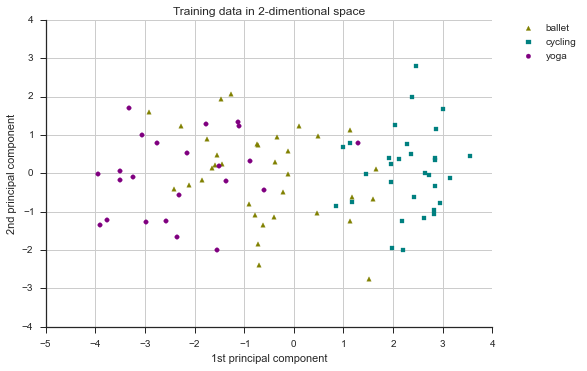

In [14]:
for l,c,m in zip(range(0,3), 
                 ('olive', 'teal', 'purple'), 
                 ('^', 's', 'o')):
    plt.scatter(train_2d[target==l, 0], 
                train_2d[target==l, 1],
                color=c,
                label=labels[l],
                marker=m)
    
plt.xlabel('1st principal component')
plt.ylabel('2nd principal component')
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.,
           loc=2)
plt.title('Training data in 2-dimentional space')
plt.grid()
sns.despine()

There is no line that would perfectly separate the three classes. However the assumption behind SVM classifier is that a dataset D that is not linearly separable in N-dimentional space may be linearly separable in a higher-dimensional space M (where M > N). Thus, if we have a transformation that lifts the dataset D to a higher-dimensional D' such that  is linearly separable, then we can train SVM on D' to find a linear decision boundary that separates the classes in D'. Projecting the decision boundary found in D' back to the original space N will yield a nonlinear decision boundary. There is a nice [visualization](https://www.youtube.com/watch?v=3liCbRZPrZA) of that method.

SVM has no need to explicitly work in the higher-dimensional space at training or testing time. During training, the optimization problem only uses the training examples to compute pair-wise dot products. This is know as a "kernel trick", which is some functional transformation of the input data. Kernel functions effectively compute dot products in a higher-dimensional space M while remaining in N-dimentional space.

Let's try the classifier on my data. 

In [16]:
from sklearn.svm import SVC

The process I use for classification task is as follows:
1. Tune parameters using GridSearchCV.
2. Create and train the model.
3. Estimate model accuracy score.
4. Make predictions and estimate probability.
5. Record the result to the set and DF.
6. Review the results.
7. Visualize the model.
8. Apply probability threshold.
9. Summary

### 1. Tune parameters using GridSearchCV
Proper model selection and additional parameters is critical to achieve good performance of the classifier. 
I apply GridSearchCV parameter tuning to choose:
* the 'gamma' parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’;
* the 'C' parameter trades off misclassification of training examples against simplicity of the decision surface. A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly by giving the model freedom to select more samples as support vectors.
I use the default 'rbf' kernel, or radial basis function. 

In [98]:
# set parameter range
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-4, 4, 13)

In [99]:
from sklearn.grid_search import GridSearchCV

parameter_grid = {'C': C_range,
                  'gamma': gamma_range}

grid_search = GridSearchCV(SVC(), parameter_grid, 
                           cv=5)

In [100]:
grid_search.fit(train_std, target)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10]), 'gamma': array([  1.00000e-04,   4.64159e-04,   2.15443e-03,   1.00000e-02,
         4.64159e-02,   2.15443e-01,   1.00000e+00,   4.64159e+00,
         2.15443e+01,   1.00000e+02,   4.64159e+02,   2.15443e+03,
         1.00000e+04])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [101]:
# review the result (only the last 10 with the higest score)
sorted(grid_search.grid_scores_, 
       key=lambda x: x.mean_validation_score)[-10:]

[mean: 0.81818, std: 0.08366, params: {'C': 1000.0, 'gamma': 0.00046415888336127773},
 mean: 0.81818, std: 0.10392, params: {'C': 1000.0, 'gamma': 0.21544346900318823},
 mean: 0.81818, std: 0.08804, params: {'C': 10000.0, 'gamma': 0.00046415888336127773},
 mean: 0.81818, std: 0.10392, params: {'C': 10000.0, 'gamma': 0.21544346900318823},
 mean: 0.81818, std: 0.10392, params: {'C': 100000.0, 'gamma': 0.21544346900318823},
 mean: 0.81818, std: 0.10392, params: {'C': 1000000.0, 'gamma': 0.21544346900318823},
 mean: 0.81818, std: 0.10392, params: {'C': 10000000.0, 'gamma': 0.21544346900318823},
 mean: 0.81818, std: 0.10392, params: {'C': 100000000.0, 'gamma': 0.21544346900318823},
 mean: 0.81818, std: 0.10392, params: {'C': 1000000000.0, 'gamma': 0.21544346900318823},
 mean: 0.81818, std: 0.10392, params: {'C': 10000000000.0, 'gamma': 0.21544346900318823}]

In [102]:
# define the winner
svc_best_score = grid_search.best_score_
best_params = grid_search.best_params_

print ("The best-performing tuning parameters"
       "\nBest score: {0:.4f};"
       "\nParameters: {1}"
       .format(svc_best_score,
               best_params))

The best-performing tuning parameters
Best score: 0.8182;
Parameters: {'C': 10.0, 'gamma': 0.21544346900318823}


#### Plot Validation Curve

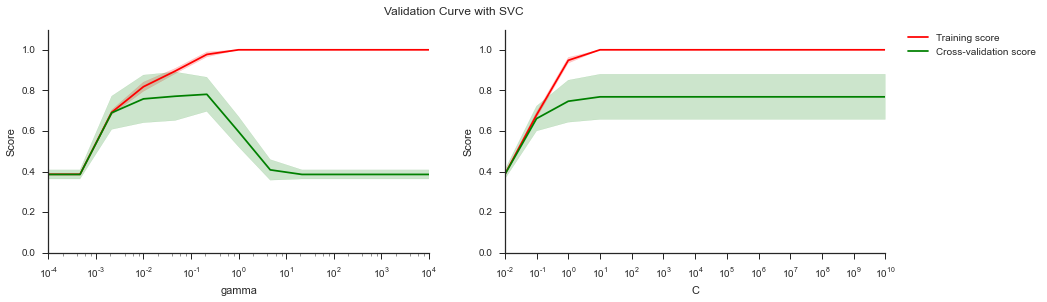

In [116]:
from sklearn.learning_curve import validation_curve

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4))
fig.suptitle("Validation Curve with SVC")

def plot_val_curve(ax, train_data, target, param_name, param_range):

    train_scores, test_scores = validation_curve(
        SVC(), train_data, target, 
        param_name=param_name, 
        param_range=param_range,
        cv=10, scoring="accuracy", n_jobs=1)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.set_xlabel(param_name)
    ax.set_ylabel("Score")
    ax.set_ylim(0.0, 1.1)
    
    ax.semilogx(param_range, train_scores_mean, label="Training score", color="r")
    ax.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color="r")
    ax.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="g")
    ax.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")

# plot gamma
plot_val_curve(ax1, train_std, target, "gamma", gamma_range)

# plot C
plot_val_curve(ax2, train_std, target, "C", C_range)

# add legend
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.,
           loc=2)
sns.despine()

In [117]:
learning_curve?

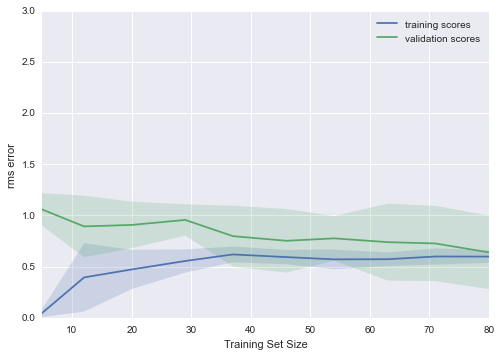

In [140]:
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import StratifiedShuffleSplit

sns.set()

def rms_error(model, train_data, target):
    y_pred = model.predict(train_data)
    return np.sqrt(np.mean((target - y_pred) ** 2))

def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

def plot_learning_curve(model, train_data, target):
    train_sizes = np.linspace(0.05, 1, 10)
    N_train, val_train, val_test = learning_curve(model, train_data, target, 
                                                  train_sizes, 
                                                  cv=StratifiedShuffleSplit(target),
                                                 scoring=rms_error)
    
    plot_with_err(N_train, val_train, label='training scores')
    plot_with_err(N_train, val_test, label='validation scores')
    plt.xlabel('Training Set Size'); plt.ylabel('rms error')
    plt.ylim(0, 3)
    plt.xlim(5, 80)
    plt.legend()
    
plot_learning_curve(svc, train_std, target)

In [125]:
learning_curve?

In [130]:

cv = StratifiedShuffleSplit(target)

In [132]:
train_sizes = np.linspace(0.05, 1, 20)
N_train, val_train, val_test = learning_curve(SVC(C=best_params['C'], 
                                                  gamma=best_params['gamma']), 
                                              train_std, target, train_sizes, cv=StratifiedShuffleSplit(target))

In [ ]:
plot_with_err(N_train, val_train, label='training scores')
plot_with_err(N_train, val_test, label='validation scores')
    plt.xlabel('Training Set Size'); plt.ylabel('rms error')
    plt.ylim(0, 3)
    plt.xlim(5, 80)
    plt.legend()



### 2. Create and train the model
Next I create a model using the parameters defined by GridSearchCV.
I also add probability=True to parameters. Training SVMs with probability=True can be quite a lot more expensive than a non-probabilistic SVM. But since it's a small set it doesn't make much difference. 

In [59]:
# create the model
svc = SVC(kernel='rbf', 
                C=best_params['C'], 
               gamma=best_params['gamma'],
               probability=True)

# train the model
svc.fit(train_std, target)

SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0, degree=3,
  gamma=0.01, kernel='rbf', max_iter=-1, probability=True,
  random_state=None, shrinking=True, tol=0.001, verbose=False)

### 3. Estimate model accuracy score
I use 10-fold cross validation.

In [60]:
from sklearn.cross_validation import cross_val_score

# calculate model accuracy score
cvs = cross_val_score(svc, train_std, target, 
                    scoring='accuracy', cv=10).mean()

In [61]:
# Build a text report showing the main classification metrics
from sklearn.cross_validation import cross_val_predict
from sklearn.metrics import classification_report
    
predicted = cross_val_predict(svc, train_std, 
                            target, cv=10)

print ("Support Vector classification model "
       "accuracy score: {:.3f}"
       .format(cvs))
print "Model report \n", 
print classification_report(target, predicted, 
                            target_names=labels)

Support Vector classification model accuracy score: 0.761
Model report 
             precision    recall  f1-score   support

     ballet       0.67      0.76      0.71        34
    cycling       0.93      0.90      0.92        31
       yoga       0.68      0.57      0.62        23

avg / total       0.77      0.76      0.76        88



The overall accuracy of the model is high. All three classes have high scores. 

The "cycling" class has the highest precision and recall ratio. That means that the pureness of model prediction for that class is 0.97 (3% of tracks assigned this class have a different label). At the same time 97% of tracks belonging to that class were identified correctly by the model.

The "ballet" class is easier to identify (88% of tracks belonging to that class were identified correctly by the model) however the precision ratio is a bit lower (0.76). It looks like some tracks from the "yoga" class were assigned the "ballet" label.

The "yoga" class has the lowest recall ratio. The precision ratio, however, is high. That means that just 17% of tracks assigned the "yoga" label have a different label but at the same time 35% of tracks with the "yoga" label were assigned a different class.

### 4. Make predictions and estimate probability
Satisfied with the model performance on the training set, I apply it to the test set to make predictions using predict method. 

In [62]:
# make predictions
# exclude index and novelty result
svc_output = svc.predict(match_test[:, 1:12])

I call predict_proba method that can predict the probability of class membership. For every query point it will calculate the probablity of belonging to each class. I use [that function](http://localhost:8888/notebooks/05_KNN_classification.ipynb#4.-Make-predictions-and-estimate-probability) from the previous post.

In [63]:
# classification probability
svc_prob = esh.class_prob(svc, match_test[:, 1:12])

### 5. Record the result
I add the model prediction and probability to the matching set and then to the DF. I store the resulting dataframe as a hdf5 file. 

In [64]:
# add the result to the matching set
svc_set = np.concatenate((match_test, svc_output[:, None], svc_prob), 1)

# review the result
print svc_set.shape
print "\nSample of the resulting set: "
svc_set[:3]

(289, 15)

Sample of the resulting set: 


array([[ 0.        , -1.20843788,  0.63488137,  1.25808605, -0.88779748,
        -0.49132844,  0.78719594, -1.1740436 , -0.39262975, -0.74488995,
         0.43101536,  0.57687657,  1.        ,  1.        ,  0.57128021],
       [ 1.        , -0.2793643 , -0.95059729, -0.59717964,  1.12009741,
         1.26151896,  0.17775694, -1.1740436 , -0.80693268,  0.63767235,
        -0.87689333, -0.01472446,  1.        ,  0.        ,  0.67971687],
       [ 2.        ,  0.72038789,  1.90749621, -0.54831972,  1.14486486,
         0.38509526, -0.33955242,  0.85175712, -0.08956489,  0.29581684,
         0.43101536,  1.24591181,  1.        ,  0.        ,  0.62825386]])

In [65]:
# transform the set back into pandas dataframe
svc_df = esh.nparray_to_df(svc_set, store)

# review the result
svc_df.sample(3)

,acousticness,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence,match,label,prob
index,,,,,,,,,,,,,,
375,-1.07,0.88,0.88,-0.91,-1.37,1.13,0.85,-0.64,-0.78,0.43,1.48,1,1,0.94
278,-1.14,0.67,0.84,0.96,0.39,0.12,0.85,-0.06,-0.62,0.43,-0.12,1,0,0.60
21,-0.20,0.42,1.08,-0.91,-0.49,0.76,-1.17,1.34,-1.35,0.43,0.73,1,0,0.58


In [66]:
# save in HDF5
svc_df.to_hdf('music_data.h5', 'svc_df', format='table')

### 6. Review the result
I use [that function](http://localhost:8888/notebooks/05_KNN_classification.ipynb#6.-Review-the-result) from the previous post.

In [67]:
# print the summary
esh.model_summary(svc_df, svc, 'Support Vector', labels, cvs)

Summary of the Support Vector classifier performance

Model: 
SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0, degree=3,
  gamma=0.01, kernel='rbf', max_iter=-1, probability=True,
  random_state=None, shrinking=True, tol=0.001, verbose=False)

Model accuracy score: 0.761

Number of tracks in the test set: 289.
Number of tracks assigned to the "ballet" class: 145, or 50.17% of all tracks.
Number of tracks assigned to the "cycling" class: 135, or 46.71% of all tracks.
Number of tracks assigned to the "yoga" class: 9, or 3.11% of all tracks.

Mean probability for each category
label
0   0.66
1   0.75
2   0.53
Name: prob, dtype: float64


### 7. Apply probability threshold
In my playlists I want to keep only tracks with high probability of class membership. To decide on the threshold for  probability estimate I plot number of tracks in each class with a threshold varying from 0 to 100%. 
#### Make a plot
I call plot_prob_thres function from the previous notebook.

In [69]:
esh.plot_prob_thres(svc_df, labels)

AttributeError: 'module' object has no attribute 'plot_prob_thres'

As in the [previous post](http://localhost:8888/notebooks/05_KNN_classification.ipynb#Make-a-plot), I apply the 0.7 probability threshold to data and review the result. It filters out some tracks in each class, eliminating tracks with lower certainty of class membership and, thus, making the playlists more accurate.

In [73]:
# print summary 
esh.summary_of_prob_with_thres(svc_df, 0.7, labels)

Total number of tracks to classify: 289.
Number of tracks with 0.7 probability of class membership: 136.
Among which...
...assigned the "ballet" class: 55 (145 without the threshold).
...assigned the "cycling" class: 80 (135 without the threshold).
...assigned the "yoga" class: 1 (9 without the threshold).

Mean probability for each class
label
0   0.76
1   0.87
2   0.70
Name: prob, dtype: float64


### Summary
In this notebook I applied **Support Vector Machine classification** tecnique to identify class membership of every track in the matching group and assign a class label. I started by tuning model parameters using scikit-learn tool GridSearchCV. I estimated model accuracy using K-fold cross validation tecnique.  

The estimated **model accuracy score** equals **0.761**.  

Model prediction results: 
* "ballet" class: 112, or 38.75% of all tracks.
* "cycling" class: 172, or 59.52% of all tracks.
* "yoga" class: 5, or 1.73% of all tracks.

The "cycling" class has the highest mean probability, which means that on average tracks are assigned this class with 83% certainty. At the same time this is the most popular class — almost 60% of all tracks in the test set are assigned the "cycling" class. 

The "ballet" class is doing alright. Almost 40% of all tracks are assigned this class label with 72% certainty on average. 

The "yoga" class has the fewest representatives in the test set. Only 5 tracks were assigned this class label. The mean probability is the lowest among the three classes (63%).

I applied 0.7 probability threshold to model predictions of class membership. As a result the "ballet" class lost 35% of tracks (73 are left), the "cycling" class lost about 24% (131 tracks left), and the "yoga" class is left with only 2 tracks (60% lost).

Data and results of this classification are stored in a HDF5 file. 

In the next post I compare the results of all applied classifiers so far.